In [3]:
import re
import os
import sys
import datetime
import itertools
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.tsa.api as smt

from matplotlib.pylab import rcParams
plt.rcParams['savefig.dpi'] = 250
plt.rcParams['figure.figsize'] = (18, 5)
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)

import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.formula.api as smf
import statsmodels.api as sm

import scipy.stats as scs
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image
from datetime import datetime

from math import sqrt
from sklearn.metrics import mean_squared_error

from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image

from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize 
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error

### Visualizar la demanda como serie de tiempo

In [4]:
#serie de tiempo en grafico
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

#leer la data del excel de los huespedes.csv
demand_data = pd.read_csv('./data/DemandaInfo.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)

#guardar en otra variable
demand_ts = demand_data['demand']

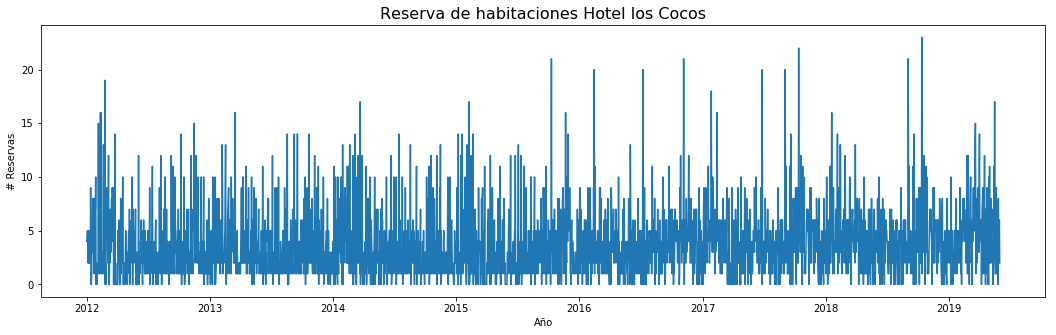

In [5]:
#imprimir la serie de tiempo
plt.plot(demand_ts, linewidth=1.5)
plt.title(u'Reserva de habitaciones Hotel los Cocos', fontsize=16)
plt.ylabel(u'# Reservas')
plt.xlabel(u'Año')
plt.show()

In [6]:
#Dividir datos de prueba y entrenamiento
y_train = demand_ts[:'2018']
y_test = demand_ts['2019':]

print(len(y_train))
print(len(y_test))

2555
151


In [7]:
#Mostrar datos

model = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=12).fit()
pred = model.predict(start=2204, end=2295)

#Volver entero predicho y muestra de informacion
prediction = list(map(lambda x: int(x), pred))
print(y_test)
print(prediction)

time
2019-01-01     5
2019-01-02     2
2019-01-03     5
2019-01-04     5
2019-01-05     3
2019-01-06     0
2019-01-07    10
2019-01-08     3
              ..
2019-05-24     3
2019-05-25     1
2019-05-26     0
2019-05-27     8
2019-05-28     3
2019-05-29     4
2019-05-30     6
2019-05-31     2
Name: demand, Length: 151, dtype: int64
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [12]:
# Simple Exponential Smoothing
fit1 = SimpleExpSmoothing(demand_ts).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(36).rename(r'$\alpha=0.2$')
print("\n fcast1 ")
print(fcast1)



fit2 = SimpleExpSmoothing(demand_ts).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(36).rename(r'$\alpha=0.6$')
print("\n fcast2 ")
print(fcast2)

fit3 = SimpleExpSmoothing(demand_ts).fit()
fcast3 = fit3.forecast(36).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
print("\n fcast3 ")
print(fcast3)



 fcast1 
2706   3.82296
2707   3.82296
2708   3.82296
2709   3.82296
2710   3.82296
2711   3.82296
2712   3.82296
2713   3.82296
         ...  
2734   3.82296
2735   3.82296
2736   3.82296
2737   3.82296
2738   3.82296
2739   3.82296
2740   3.82296
2741   3.82296
Name: $\alpha=0.2$, Length: 36, dtype: float64

 fcast2 
2706   3.27073
2707   3.27073
2708   3.27073
2709   3.27073
2710   3.27073
2711   3.27073
2712   3.27073
2713   3.27073
         ...  
2734   3.27073
2735   3.27073
2736   3.27073
2737   3.27073
2738   3.27073
2739   3.27073
2740   3.27073
2741   3.27073
Name: $\alpha=0.6$, Length: 36, dtype: float64

 fcast3 
2706   4.71046
2707   4.71046
2708   4.71046
2709   4.71046
2710   4.71046
2711   4.71046
2712   4.71046
2713   4.71046
         ...  
2734   4.71046
2735   4.71046
2736   4.71046
2737   4.71046
2738   4.71046
2739   4.71046
2740   4.71046
2741   4.71046
Name: $\alpha=0.016050658133634235$, Length: 36, dtype: float64


In [13]:
fit1 = Holt(demand_ts).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")

print(fcast1)

fit3 = Holt(demand_ts, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast3 = fit3.forecast(12).rename("Additive damped trend")

print("\n fcast3 ")
print(fcast3)


2706    2.51459
2707    2.23824
2708    1.96190
2709    1.68555
2710    1.40920
2711    1.13285
2712    0.85651
2713    0.58016
2714    0.30381
2715    0.02746
2716   -0.24888
2717   -0.52523
Name: Holt's linear trend, dtype: float64

 fcast3 
2706   2.71754
2707   2.71754
2708   2.71754
2709   2.71754
2710   2.71754
2711   2.71754
2712   2.71754
2713   2.71754
2714   2.71754
2715   2.71754
2716   2.71754
2717   2.71754
Name: Additive damped trend, dtype: float64


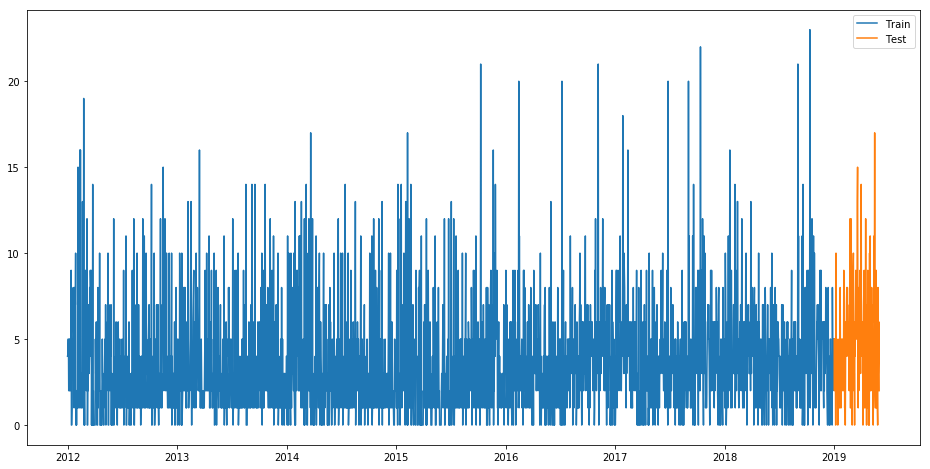

[5, 2, 5, 5, 3, 0, 10, 3, 4, 5, 3, 2, 0, 2, 2, 4, 5, 3, 1, 1, 8, 3, 2, 1, 5, 3, 2, 2, 5, 4, 4, 2, 9, 6, 5, 1, 2, 0, 4, 6, 4, 7, 8, 5, 8, 6, 4, 4, 5, 6, 2, 7, 3, 12, 1, 1, 12, 10, 4, 6, 0, 5, 4, 9, 10, 5, 2, 3, 0, 6, 4, 7, 9, 6, 6, 5, 5, 13, 15, 6, 1, 5, 2, 8, 8, 8, 9, 5, 3, 9, 14, 4, 6, 5, 4, 6, 0, 5, 7, 8, 9, 1, 2, 2, 5, 12, 1, 7, 0, 5, 1, 5, 9, 2, 3, 0, 3, 0, 10, 5, 11, 2, 8, 2, 3, 8, 5, 7, 2, 3, 0, 2, 3, 11, 6, 17, 2, 1, 1, 5, 9, 1, 6, 3, 1, 0, 8, 3, 4, 6, 2]


In [14]:
y_hat_avg = y_test.copy()
fit1 = ExponentialSmoothing(np.asarray(y_train) ,seasonal_periods=12, seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(y_test))
plt.figure(figsize=(16,8))
plt.plot( y_train, label='Train')
plt.plot(y_test, label='Test')
#plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()
my_list = []
for i in range(len(y_hat_avg.values)-1):
    my_list.append(y_hat_avg.values[i])
print(my_list)
